In [11]:
%cd ~/code/python/calthunder/wp2/repo
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import nicefigs
from metpy.plots import SkewT
from metpy.units import units
import ConvParams.physics as phys
import ConvParams.parcel as parcel
import ConvParams.thermo as thermo
import ConvParams.wind as wind

/home/565/raw565/code/python/calthunder/wp2/repo


87953.80304872816 82301.71473916245 23237.147180461427
1210.6783323605657 4.942801425717863 1002.5068328699285
92547.41944392626 88564.33452130624 21864.191688310224
1956.7653119998558 1.2072439811101379 633.2391860452408


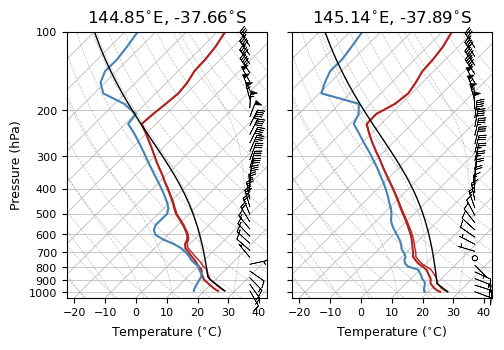

In [12]:
# Input file
#filepath = 'data/access-g.1.20200119.0000.an.nc'
filepath = 'data/access-g.1.20200119.0600.an.nc'

# Coordinates at which to plot profiles
#lons = [144.85, 145.46]   # 00Z
#lats = [-37.66, -37.79]   # 00Z
lons = [144.85, 145.14]   # 06Z
lats = [-37.66, -37.89]   # 06Z

n_prof = len(lons)

# Skew-T settings
Tmin = -22.5
Tmax = 42.5
Ttitle = 'Temperature ($^{\circ}$C)'
ptitle = 'Pressure (hPa)'
pmin = 100
pmax = 1050
aspect = 1.33

# Figure settings
nrows = 1
ncols = n_prof
xsize = 2.0
ysize = xsize * aspect
xspace = 0.25
yspace = 0.25
lmargin = 0.5
rmargin = 0.5
bmargin = 1.0
tmargin = 0.5
fig_dict = {'nrows': nrows, 'ncols': ncols,
            'xsize': xsize, 'ysize': ysize,
            'xspace': xspace, 'yspace': yspace,
            'lmargin': lmargin, 'rmargin': rmargin,
            'bmargin': bmargin, 'tmargin': tmargin}

# Initialise plot counter
pcount = 0

# Set figure
xfig, yfig = nicefigs.get_figsize(fig_dict)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(xfig,yfig), dpi=100)
nicefigs.set_fig(fig_dict)

# Get rid of axes
if ncols > 1 or nrows > 1:
    [ax.set_axis_off() for ax in axs.ravel()]
else:
    axs.set_axis_off()

# Adjust text properties
nicefigs.textprops(titlesize=12, labelsize=9, ticklabelsize=8)

# Set x position for wind barbs
xloc = (37.0 - Tmin) / (Tmax - Tmin)

# Loop over profiles
for lon, lat in zip(lons, lats):
   
    # Read in profile data
    with xr.open_dataset(filepath) as ds:
        ds = ds.sel(lon=lon, lat=lat, method='nearest')
        p = ds['pressure'].values.squeeze()
        T = ds['air_temp'].values.squeeze()
        q = ds['spec_hum'].values.squeeze()
        u = ds['wnd_ucmp'].values.squeeze()
        v = ds['wnd_vcmp'].values.squeeze()
    
    # Note the number of levels
    n_lev = len(p)
            
    # Compute dewpoint profile
    Td = np.zeros_like(T)
    for k in range(n_lev):
        Td[k] = phys.dwpt_temp(p[k], T[k], q[k])
    
    # Compute relative humidity profile
    RH = phys.rel_hum(p, T, q)
    
    # Compute virtual temperature profile
    Tv = phys.virt_temp(T, q)
        
    # Create parcel virtual temperature profile
    Tp = np.zeros(n_lev)
    qp = np.zeros(n_lev)
    p_lcl, Tp_lcl = phys.lift_cond_level(p[0], T[0], q[0])
    qp_lcl = phys.sat_spec_hum(p_lcl, Tp_lcl)
    for k in range(n_lev):
        if p[k] > p_lcl:
            Tp[k] = phys.dry_adiabat(p_lcl, Tp_lcl, qp_lcl, p[k])
            qp[k] = qp_lcl
        else:
            Tp[k] = phys.sat_adiabat(p_lcl, Tp_lcl, p[k])
            qp[k] = phys.sat_spec_hum(p[k], Tp[k])
    Tvp = phys.virt_temp(Tp, qp)
    
    # Create height profile
    dz = (phys.Rd / phys.g) * 0.5 * (Tv[:-1] + Tv[1:]) * np.log(p[:-1] / p[1:])
    z = np.zeros(n_lev)
    z[1:] = np.cumsum(dz, axis=0)
    
    # Get parcel parameters
    pcl = parcel.parcel_ascent(z, p, T, q, z[0], p[0], T[0], q[0])
    p_lcl = pcl['LCLp']
    p_lfc = pcl['LFCp']
    p_el = pcl['ELp']
    print(p_lcl, p_lfc, p_el)
    print(pcl['CAPE'], pcl['CIN'], pcl['LCLz'])
        
    # Interpolate winds to height levels every 1 km
    znew = np.arange(0, 16000, 500)
    pnew = np.exp(np.interp(znew, z, np.log(p)))
    unew = np.interp(znew, z, u) * 1.94384
    vnew = np.interp(znew, z, v) * 1.94384
    
    # Create Skew-T axes
    pindex, row, col = nicefigs.set_pos(pcount, nrows, ncols)
    skewt_aspect = aspect * (Tmax - Tmin) / np.log10(pmax/pmin)
    skew = SkewT(fig, subplot=(nrows,ncols,pindex), rotation=45,
                 aspect=skewt_aspect)

    # Plot dry and moist adiabats
    Tvals = np.arange(-20,160,10) * units.degC
    skew.plot_dry_adiabats(t0=Tvals, colors='grey', linewidth=0.5, zorder=1)
    Tvals = np.arange(-20,40,10) * units.degC
    skew.plot_moist_adiabats(t0=Tvals, colors='grey', linewidth=0.5, zorder=1)

    # Add temperature and dewpoint profiles
    skew.plot(p/100, T-273.15, color='firebrick', linewidth=1.5, zorder=2)
    skew.plot(p/100, Td-273.15, color='steelblue', linewidth=1.5, zorder=2)
    
    # Add environmental virtual temperature profile
    skew.plot(p/100, Tv-273.15, color='firebrick', linewidth=1, zorder=2)

    # Add parcel virtual temperature profile
    skew.plot(p/100, Tvp-273.15, color='black', linewidth=1, zorder=2)

    # Add wind barbs
    skew.plot_barbs(pnew/100, unew, vnew, xloc=xloc, barbcolor='black', length=5, linewidth=0.5)
    
    # Add lines showing LCL, LFC, and EL
    skew.plot([p_lcl, p_lcl], [-100, 100], color='black', linewidth=0.5, linestyle='--')
    skew.plot([p_lfc, p_lfc], [-100, 100], color='black', linewidth=0.5, linestyle='--')
    skew.plot([p_el, p_el], [-100, 100], color='black', linewidth=0.5, linestyle='--')
    
    # Plot axes
    skew.ax.grid(linewidth=0.5)
    if (row == 1):
        skew.ax.set(xlim=(Tmin,Tmax), xlabel=Ttitle)
    else:
        skew.ax.set(xlim=(Tmin,Tmax), xlabel='')
    if (col == 1):
        skew.ax.set(ylim=(pmax,pmin), ylabel=ptitle)
    else:
        skew.ax.set(ylim=(pmax,pmin), yticklabels='', ylabel='')
        
    # Plot title
    title = '{:.2f}'.format(lon) + '$^{\circ}$E, ' + '{:.2f}'.format(lat) + '$^{\circ}$S'
    plt.title(title)
        
    # Increment plot counter
    pcount += 1
    
filename = f'/home/565/raw565/plots/calthunder/wp2/Melb_profs.png'
plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')